# **Homework 2 - Word Sense Disambiguation** 

## Imports

In [1]:
# import stuffs
from src.data_module import WSD_DataModule, WSD_Gloss_DataModule
from src.hyperparameters import Hparams
from src.train import train_model
from src.model import WSD_Model, WSD_Gloss_Model
from src.utils import one_group_bar, plot_histogram, evaluation_pipeline

import torch
from torch import nn
from collections import Counter
import random
from tqdm import tqdm
import numpy as np
import json
import wandb
from dataclasses import asdict
import pytorch_lightning as pl
from torchmetrics import Accuracy

# to have a better workflow using python notebooks
%load_ext autoreload
%autoreload 2

In [2]:
# setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    _ = pl.seed_everything(seed)
set_seed(1999)

Global seed set to 1999


## Look at the data! 👀

The first thing to do before starting a new deep learning project is to look at the data! Without a quality dataset there's no way of achieving good results. In fact, a good *pre-processing* pipeline is a necessary condition for a high-quality **WSD system**. In the present case, the given dataset is quite *clean* and does not required much work but anyway there's always room for improvement.
The significance of this aspect is frequently disregarded as WSD systems commonly depend on pre-parsed documents that have already been divided into sentences, tokenized, lemmatized, and POS-tagged (like in our dataset), but nothing should be taken for granted!

> In our approach to WSD, we employ a supervised method that involves training machine learning models on *sense-annotated* data. The first thing to do is indeed to create and define a **sense inventory**, that is the set of all possible senses for all the words involved in the task. The senses are *synsets* from ***WordNet*** and express the different meanings of a word. Therefore the engineering process of defining the correct candidate set of possible meanings remains central to the overall disambiguation process. Fortunately this work has already been done :)

We are going to address two different WSD approaches:
-   **fine-grained WSD**: the senses are the ones form WordNet and it aims to provide more precise and detailed sense distinctions.
-   **coarse-grained WSD**: where we cluster the similar senses of a polysemous word to obtain a smaller number of sense distinctions. This approach aims to provide a higher-level understanding of word meanings, focusing on more general sense categories.


### Sense inventory 📚

After making some reasonings, the easiest thing to do for build the sense invenctory was to take all the senses stored in the '*coarse_fine_defs_map.json*' file provided to us. We made all the possible checks to see if all the senses annotated in *train/val/test* datasets were not excluded and that's fortunately the case. 

> Of course the built sense inventory doesn't cover all the possible senses of all the possible polysemous words. Therefore I also implemented the logic for handle cases where the senses for the word to disambiguate are not present. In few words, by not cheating, if at least one sense among the candidate ones of the particular sample is \<UNK\>, the sense prediction will be <UNK> and consequently wrong.

Saying that, there won't be these kind of problems when using *train/val/test* sets.

In [3]:
# TOTAL NUMBER OF SENSES for coarse-grained WSD
hparams = asdict(Hparams()) # instantiate hyperparamters file
d = json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r"))
all_senses_list = list(d.keys()) # 2158
print(f"Length of sense inventory for coarse-grained WSD is {len(all_senses_list)}")

Length of sense inventory for coarse-grained WSD is 2158


In [4]:
# Since we are dealing with neural networks we need to encode the sense invectory and simply create a mapping between 
# coarse-grained senses and indices.

# let's build sense2id and id2sense map for coarse-grained senses
sense2id = {}
id2sense = {}

idx=0
for sense in all_senses_list:
    sense2id[sense] = idx
    id2sense[idx] = sense
    idx+=1

sense2id["<UNK>"] = idx
id2sense[idx] = "<UNK>"
    
json.dump(sense2id, open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "w"))
json.dump(id2sense, open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "w"))

In [5]:
data = WSD_DataModule(hparams)
data.setup()

# TOTAL NUMBER OF TRAIN SENSES for coarse-grained WSD
all_senses_train = []
for batch in tqdm(data.train_dataloader()):
    for candidate_set in batch["candidates"]:
        for candidate in candidate_set:
            all_senses_train.append(candidate)            
c_train = Counter(all_senses_train)
print(f"Total senses for train dataset: {len(c_train)}") # 1933

# TOTAL NUMBER OF TRAIN SENSES for coarse-grained WSD
all_senses_val = []
for batch in tqdm(data.val_dataloader()):
    for candidate_set in batch["candidates"]:
        for candidate in candidate_set:
            all_senses_val.append(candidate)
c_val = Counter(all_senses_val)
print(f"Total senses for val dataset: {len(c_val)}") # 750

# TOTAL NUMBER OF TRAIN SENSES for coarse-grained WSD  
all_senses_test = []
for batch in tqdm(data.test_dataloader()):
    for candidate_set in batch["candidates"]:
        for candidate in candidate_set:
            all_senses_test.append(candidate)
c_test = Counter(all_senses_test)
print(f"Total senses for test dataset: {len(c_test)}") # 781

100%|██████████| 307/307 [02:07<00:00,  2.42it/s]


Total senses for train dataset: 2086


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


Total senses for val dataset: 750


100%|██████████| 18/18 [00:08<00:00,  2.08it/s]

Total senses for test dataset: 781


In [6]:
# CHECK that all senses present in train/val/test are included in the SENSE INVENTORY
all_senses_list = [sense2id[e] for e in all_senses_list] # we encode the senses
i=0 
for s in list(c_train.keys()):
    if s not in all_senses_list:
        print(s)
        i+=1
assert i==0

i=0 
for s in list(c_val.keys()):
    if s not in all_senses_list:
        i+=1
assert i==0

i=0   
for s in list(c_test.keys()):
    if s not in all_senses_list:
        i+=1
assert i==0

> 🔥 *Sense inventory* comprehend all our dataset coarse-grained senses! 

We do the same thing for **fine-grained** senses thanks to '*coarse_fine_defs_map.json*' file. The check we've done before it's now useless to perform since fine-grained senses are included in coarse-grained ones.

In [7]:
# let's build sense2id and id2sense map for fine-graned senses
d = json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r"))
all_senses_list = [] # 4476
for k in d.keys():
    for fine_s in d[k]:
        all_senses_list.append(list(fine_s.keys())[0])
print(f"Length of sense inventory for fine-grained WSD is {len(all_senses_list)}")

sense2id = {}
id2sense = {}

idx=0
for sense in all_senses_list:
    sense2id[sense] = idx
    id2sense[idx] = sense
    idx+=1

sense2id["<UNK>"] = idx
id2sense[idx] = "<UNK>"
    
json.dump(sense2id, open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "w"))
json.dump(id2sense, open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "w"))

Length of sense inventory for fine-grained WSD is 4476


In [8]:
# Because of some approaches I'll develop later I need 
# to build a direct mapping between fine and coarse-grained (we already have the opposite mapping)

d = json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r"))
fine2coarse = {}
for k in d.keys():
    for fine_s in d[k]:
        fine2coarse[list(fine_s.keys())[0]] = k

json.dump(fine2coarse, open(hparams["prefix_path"]+"model/files/fine2coarse.json", "w"))

### Data Analysis 🧮

> Let's make a quick quantitative analysis for facing what the dataset and the task is about.

**Number of candidates histogram**

100%|██████████| 18/18 [00:07<00:00,  2.44it/s]


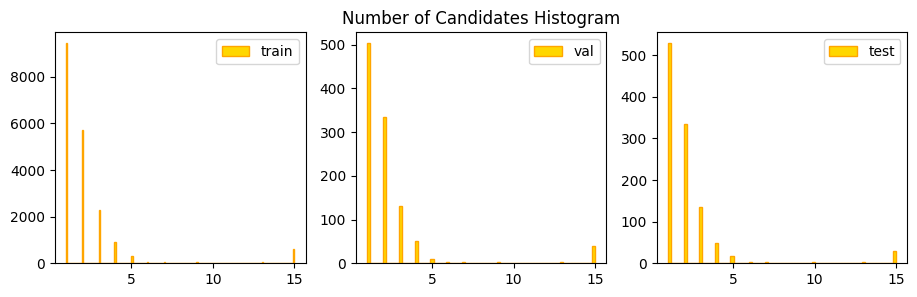

In [9]:
data = WSD_DataModule(hparams)
data.setup()
num_candidates = []

num_candidates_train = []
for batch in tqdm(data.train_dataloader()):
    for candidate_set in batch["candidates"]:
        num_candidates_train.append(len(candidate_set))
num_candidates.append(num_candidates_train)
        
num_candidates_val = []
for batch in tqdm(data.val_dataloader()):
    for candidate_set in batch["candidates"]:
        num_candidates_val.append(len(candidate_set))
num_candidates.append(num_candidates_val)
        
num_candidates_test = []
for batch in tqdm(data.test_dataloader()):
    for candidate_set in batch["candidates"]:
        num_candidates_test.append(len(candidate_set))
num_candidates.append(num_candidates_test)
    
plot_histogram(num_candidates, multiple=True, title="Number of Candidates Histogram")

> 💡 We can say for sure that the three splits represent the same data distribution (and this is already a good starting point). It's quite obvious that most of polysemous words have the range of possible meanings between 1 and 5. The only one coarse-grained sense is most likely case and this, of course, will help to increase my models performance (in the fine-grained case this doesn't stand anymore). <br> But the thing that immediately stands out is the presence of words with more than 5 possible "coarse" meanings! In particular the 15 case!

For this reason I'm going to save all candidate sets which have a length bigger than or equal to 5 for keeping track of my models performance on them (which should be the hardest cases!). 

In [10]:
# I want to compute and actually see which are the most difficult (theoretically) words to disambiguate
# (an example is 'hall', 'find', 'stone', 'bound', 'bore', 'found' etc.)
hard_words_to_disambiguate = []

for batch in tqdm(data.train_dataloader()):
    for candidate_set in batch["candidates"]:
        if len(candidate_set) >= 5:
            candidate_set = [id2sense[e] for e in candidate_set]
            candidate_set.sort()
            if (len(candidate_set), candidate_set) not in hard_words_to_disambiguate:
                hard_words_to_disambiguate.append((len(candidate_set), candidate_set))
for batch in tqdm(data.val_dataloader()):
    for candidate_set in batch["candidates"]:
        if len(candidate_set) >= 5:
            candidate_set = [id2sense[e] for e in candidate_set]
            candidate_set.sort()
            if (len(candidate_set), candidate_set) not in hard_words_to_disambiguate:
                hard_words_to_disambiguate.append((len(candidate_set), candidate_set))
for batch in tqdm(data.test_dataloader()):
    for candidate_set in batch["candidates"]:
        if len(candidate_set) >= 5:
            candidate_set = [id2sense[e] for e in candidate_set]
            candidate_set.sort()
            if (len(candidate_set), candidate_set) not in hard_words_to_disambiguate:
                hard_words_to_disambiguate.append((len(candidate_set), candidate_set))

hard_words_to_disambiguate.sort(key=lambda x:x[0])
print(f"There are {len(hard_words_to_disambiguate)} polysemous words which are harder to disambiguate for their many meanings!")
print(hard_words_to_disambiguate)

hard_words_to_disambiguate_dict = {}
for i in range(len(hard_words_to_disambiguate)):
    hard_words_to_disambiguate_dict[i] = hard_words_to_disambiguate[i][1]
json.dump(hard_words_to_disambiguate_dict, open(hparams["prefix_path"]+"model/files/hard_words_to_disambiguate.json", "w"))

100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

There are 44 polysemous words which are harder to disambiguate for their many meanings!
[(5, ['bank.n.01', 'hamper.n.02', 'old_world_buffalo.n.01', 'pinch.v.01', 'rice.n.02']), (5, ['aureole.n.01', 'compound.n.02', 'hail.v.03', 'stake.n.05', 'tag.v.02']), (5, ['bank.n.03', 'diet.n.01', 'doorkeeper.n.03', 'pique.v.01', 'promethium.n.01']), (5, ['bowl.n.01', 'buffalo.n.03', 'dock.v.01', 'grouch.n.01', 'pop.n.02']), (5, ['bastardly.s.02', 'batting.n.02', 'chilliness.n.01', 'love_affair.n.01', 'star.n.04']), (5, ['farad.n.01', 'golf_club.n.02', 'hour.n.01', 'rig.n.01', 'rim.v.01']), (5, ['acme.n.01', 'diligence.n.01', 'forge.v.04', 'time.n.01', 'white.n.08']), (5, ['bile.n.01', 'meal.n.03', 'refreshment.n.02', 'staff.n.06', 'trap.n.01']), (5, ['bone.n.03', 'buffet.n.02', 'crackpot.n.01', 'grade.n.07', 'present.n.03']), (5, ['chopin.n.02', 'clairvoyance.n.01', 'dressing_table.n.01', 'field.n.13', 'wax.v.01']), (5, ['line.v.01', 'lineage.n.01', 'quarrel.v.01', 'sound.v.06', 'trial.n.02']), (

**Least frequent senses**

> Another thing I want to see is which are the least frequent word senses in the *training* set. In this way I can understand and acknowledge which are the cases where my models will hypothetically suffer.

In [11]:
l = []
for batch in tqdm(data.train_dataloader()):
    for label in batch["labels"]:
        l.append(id2sense[label])
c = Counter(l)

100%|██████████| 307/307 [01:14<00:00,  4.12it/s]


STATISTICS:
| mean: 13.907026259758695
| std: 33.80217172986219
| min: 1
| max: 509


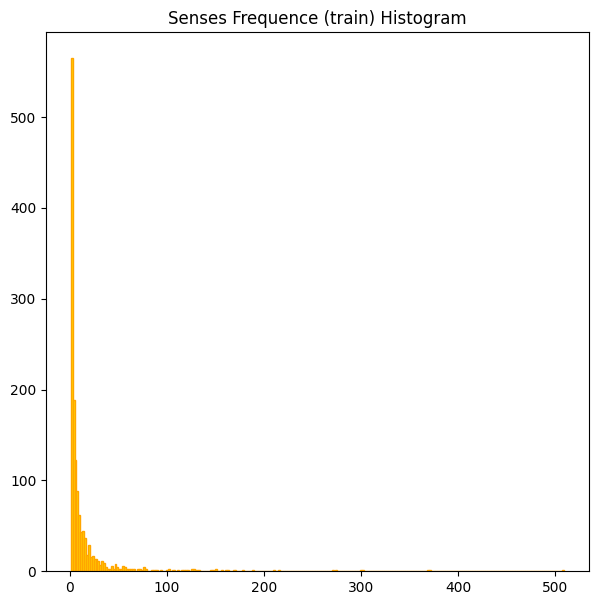

In [12]:
# just want to show the frequence histogram of each coarse-grained sense
senses_frequence_list = list(c.values())
plot_histogram(senses_frequence_list, title="Senses Frequence (train) Histogram")

> 💡 This is exactly the **Zipf distribution**: the reason why WSD is not a trivial task at all. It shows us that few senses occur very frequently while the majority of senses occur relatively infrequently! 

It doesn't make much sense to show the least training frequent senses because they are too many, but anyway I'm going to show for the sake of curiosity the least 70 frequent ones.

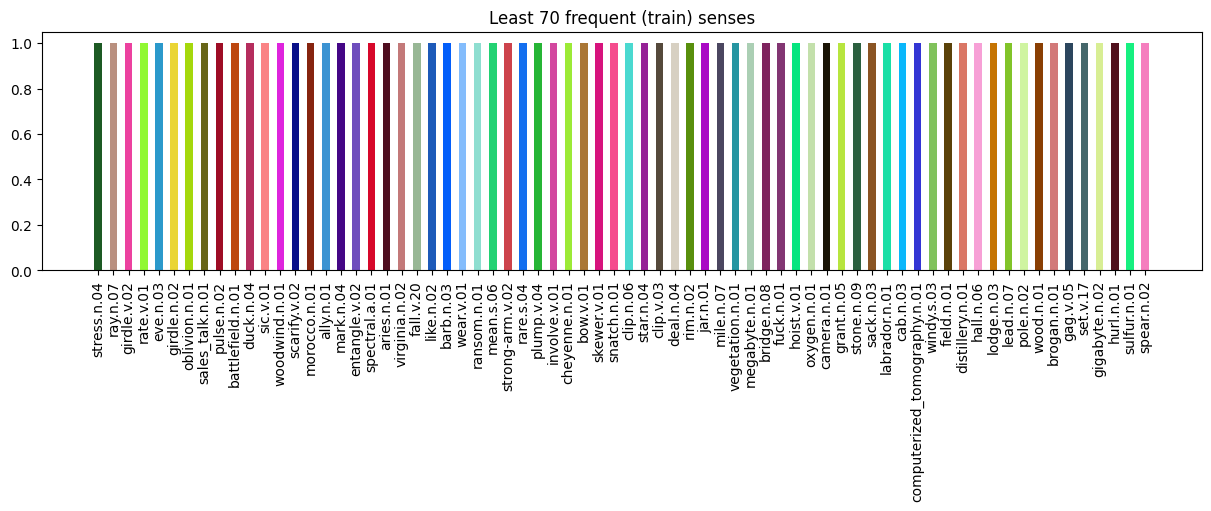

In [13]:
least_common_senses = c.most_common(len(c))[-70:]
columns = [e[0] for e in least_common_senses]
data = [[e[1] for e in least_common_senses]]
title = "Least 70 frequent (train) senses"
one_group_bar(columns, data, title)

### Preprocessing ♻

> 🔸 As I've already mentioned the most difficult and time consuming part has been taken over by those who have made the dataset (collecting all candidate senses for each polysemous word and deciding which are the words worth the disambiguation). It would have been particularly boring for me to check if all sense synsets were coherent and there weren't any kind of inconsistency. Hence, holding a certain level of confidence in the dataset, I deem the examination I conducted on including all the senses within the sense inventory to be acceptable enough for this assignment.

> For this task, where we were allowed to use *Transformers*, all the pipeline part of building the vocabulary and all the concern about generating as few \<UNK\> tokens as possible does not exist anymore! 

Let's see why I'm telling this:

In [15]:
# let's see how many <UNK> token we generate without any particular type of preprocessing!
data = WSD_DataModule(hparams)
data.setup()

tot_tokens = 0
tot_unk = 0
for batch in tqdm(data.train_dataloader()):
    for input in batch["inputs"]["input_ids"]:
        for e in input:
            if e.item() == 0: # we reached <PAD> tokens
                break
            tot_tokens+=1
            if e.item() == 100: # is the <UNK> token
                tot_unk+=1
print(f"We have a total of {tot_tokens} tokens")
print(f"with {tot_unk} <UNK> tokens!")

100%|██████████| 307/307 [01:40<00:00,  3.05it/s]

We have a total of 1024361 tokens
with 0 <UNK> tokens!


> 🔥 It's unbelievable how, thanks to the **BERT Tokenizer** (*WordPiece*), we generate zero \<UNK\> tokens!

#### Clean tokens 🧹

With respect to the first homework the *cleaning* operations (also due the power of *BERT Tokenizer*) are very basic and not "aggressive".

> 🔸 The function I implemented is "*clean_tokens*" from the *data_module.py* file. Of course, this function is applied to all the dataset splits (*train/val/test*).

#### Filter sentences 🥅

Another important step before finishing the preprocessing part, is to filter out the *training* sentences. This is something it has to be done only at training time because the test/val datasets don't have to be touched in this sense. <br> Let's first see which is the histogram of sentences length.

STATISTICS:
| mean: 40.80873652646081
| std: 15.559684644064761
| min: 3
| max: 289


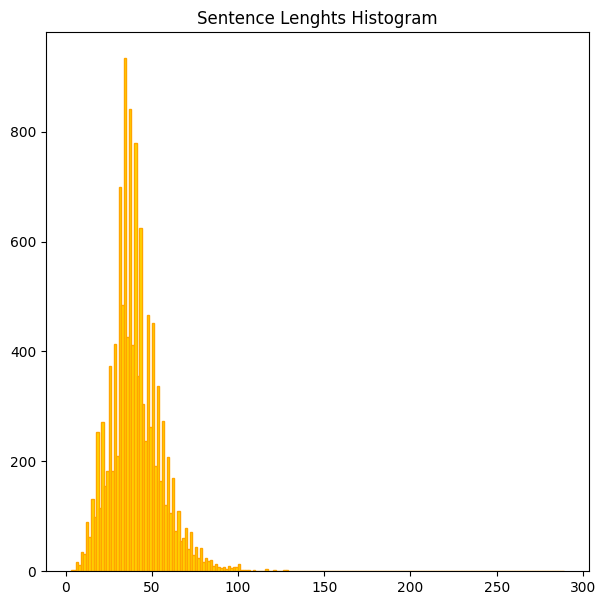

In [16]:
# sentence length histogram
from src.utils import read_dataset
train_sentences, _ = read_dataset(hparams["prefix_path"]+hparams["data_train"])
sent_lengths_list = [len(item["words"]) for item in train_sentences]
    
plot_histogram(sent_lengths_list)

As we can see there are some "sentence *outliers*" which deviates from the majority of data and this is not good in machine learning because our aim is always to learn a data distribution. Actually the mean value is 40, but we have the maximum sentence length that reaches 289. This kind of training samples have to be avoided in order to not make the model learn other type of distribution. <br> Saying that, the first step to do is to filter sentences based on their length. I've choosen to set *min_sent_length=5* and *max_sent_length=85* as length bounds and they appeared to work pretty good. During the filtering I also check that in each sentence there's at least one word to disambiguate.

STATISTICS:
| mean: 40.07812756189539
| std: 13.634353717050384
| min: 5
| max: 85


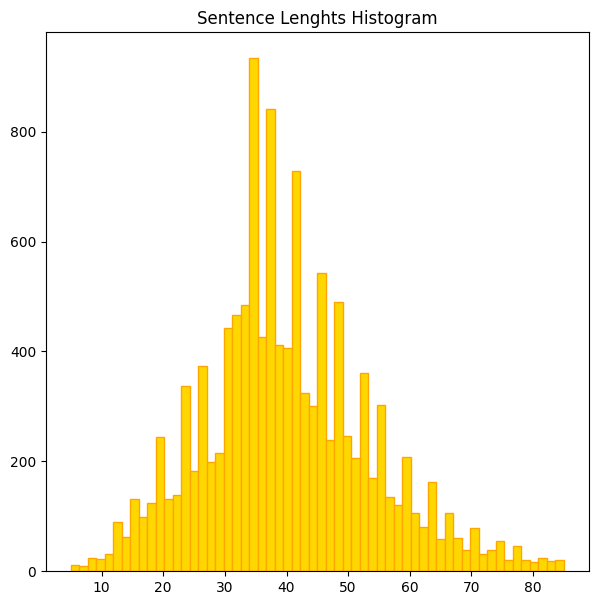


| After the filtering we've lost only the 1.14% of original training sentences! |


In [17]:
# filtering the sentences (the actual function is implemented in "data_module.py")
from src.utils import read_dataset
train_sentences, _ = read_dataset(hparams["prefix_path"]+hparams["data_train"])

sent_lengths_list = []
tot_sentences, filtered_sentences = 0, 0
for item in train_sentences:
    assert len(item["instance_ids"].keys()) != 0
    tot_sentences += 1
    if len(item["words"])< 5 or len(item["words"])> 85:
        filtered_sentences += 1
        continue
    sent_lengths_list.append(len(item["words"]))

plot_histogram(sent_lengths_list)
print()
print(f"| After the filtering we've lost only the {round((filtered_sentences/tot_sentences)*100,2)}% of original training sentences! |")

> 🔸 Look now how good the shape is looking! Only *1.14%* of sentences are excluded (141 sentences). The function I implemented to do this filtering is "*filter_sentences*" from the *data_module.py* file and is only applied to *training* data.

## Models 🏛

### Architecture

The most intuitive way of treating the problem is to see the WSD system as a ***Multiclass Token Classification***. There are some SOTA works which frame WSD as a *multi-label* classification problem, arguing that forcing a system to treat WSD as a *single-label* classification problem and
learning that only one sense is correct for a word in a given context does not reflect how human beings disambiguate text (and I agree with this statement). But for the sake of simplicity I approached the task as a *single-label* problem.

The model architecture is a "simple" composition of an **Embedding layer**, a **Transformer encoder** and at the end a **Classifier**. <br> 
*   **Bert**, **Roberta** and **Deberta** transformers architecture as ***FastTokenizers*** for the tokenization part and ***Encoders*** for the encoding part.
*   **Classifier**: starting from the implementation of some papers produced by the *Sapienza NLP* group about WSD, I structured it in two layers. The first is **non-linear** and is anticipated by a batch normalization operation. As activation function I tried the strongly suggested *SiLu* and also *ReLu*. Here an important hyperparameter to tweak is the dimension in which transform the encoded text. The last layer is a simple **linear layer** which project the latent vector into the sense inventory space. 

The output of the WSD system provides a probability (thanks to a softmax) for each sense of the inventory. The model is trained to maximize the probability of the single most appropriate sense by minimizing a **cross-entropy** loss. At prediction time we focus on target senses only, which means we are going to choose only from the candidates set of the word under consideration.

> 💡 Since we have the ***pos tags*** and ***lemmas*** "for free", I've also tried to involve them in the system. For example, using the lemmas of the words as input to the Transformers instead of the words themselves. Furthermore, I exploited the pos tags of the words to disambiguate by giving them as input to the Transformer encoder after input sentence *\[CLS\] input_sentence \[SEP\] pos_tag \[SEP\]*. 

### Hparams Tables

**Baseline**

<br>
<table>
  <tr>
    <th><center>hparams</center></th>
    <th><center> </center></th>
  </tr>
  <tr>
    <td><center>fine_tune_bert</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>encoder_type</center></td>
    <td><center>bert</center></td>
  </tr>
    <tr>
    <td><center>encoder_size</center></td>
    <td><center>768</center></td>
  </tr>
    <tr>
    <td><center>hidden_dim</center></td>
    <td><center>256</center></td>
  </tr>
    <tr>
    <td><center>act_fun</center></td>
    <td><center>silu</center></td>
  </tr>
   <tr>
    <td><center>dropout</center></td>
    <td><center>0</center></td>
  <tr>
    <tr>
    <td><center>⚡ precision</center></td>
    <td><center>16</center></td>
  </tr>
  </tr>
    <tr>
    <td><center>⚡ use_POS</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>⚡ use_lemmas</center></td>
    <td><center>False</center></td>
  </tr>
 

</table>
<br>

**Base model *(best configuration)***

<br>
<table>
  <tr>
    <th><center>hparams</center></th>
    <th><center> </center></th>
  </tr>
  <tr>
    <td><center>fine_tune_bert</center></td>
    <td><center>True</center></td>
  </tr>
    <tr>
    <td><center>encoder_type</center></td>
    <td><center>bert</center></td>
  </tr>
    <tr>
    <td><center>encoder_size</center></td>
    <td><center>768</center></td>
  </tr>
    <tr>
    <td><center>hidden_dim</center></td>
    <td><center>512</center></td>
  </tr>
    <tr>
    <td><center>act_fun</center></td>
    <td><center>relu</center></td>
  </tr>
   <tr>
    <td><center>dropout</center></td>
    <td><center>0.6</center></td>
  <tr>
    <tr>
    <td><center>⚡ precision</center></td>
    <td><center>16</center></td>
  </tr>
  </tr>
    <tr>
    <td><center>⚡ use_POS</center></td>
    <td><center>True</center></td>
  </tr>
    <tr>
    <td><center>⚡ use_lemmas</center></td>
    <td><center>False</center></td>
  </tr>
 

</table>
<br>

### *Fine vs Coarse-grained*

We can do a lot of experiments and comparative analysis by using Fine/Coarse-grained WSD models to perform Fine/Coarse-grained WSD tasks. 
Let's see what we can do:
*   Test all my models on *fine-grained* task and compare their perfomances with respect to the coarse one. 
*   Use a *fine-grained* model to predict *coarse-grained* senses. We can employ two strategies:
    *   leverage a fine-grained model trained on fine-grained task and simply use it for coarse-grained inference.
    *   instead, we can train the fine-grained model by giving a reward each time it predicts a fine-grained sense in the correct homonym set (we indeed change the loss function). At prediction time, we use it as in the previous case.
*   Employ a *coarse-grained* model to *filter out* fine senses of a fine-grained model during inference.


> 🔍 See how the hyperparameters ***coarse_loss_oriented***, ***predict_coarse_with_fine*** and ***predict_fine_with_coarse_filter*** are used to make all the experiments explained above happen in "*predict*" and "*loss_function*" methods in *WSD_Model* class.

### *Gloss Models*

As suggested by TAs, I decided to employ synsets definitions (hence **glosses**) in my pipeline. ***How?*** <br> <br> Following the idea of **GlossBert**. Basically, for each word to disambiguate we construct the so called *context-gloss* pairs. The sentence containing the target word is denoted as context sentence. For each target word, we extract the glosses of all possible senses of the target word in WordNet to obtain the gloss sentence. The input will be *\[CLS\] context_sentence \[SEP\] gloss \[SEP\]*. <br> The bert-encoded target word is then fed into a binary classification layer (label ∈ {yes, no}). We want the model to learn if the relative gloss is the one which defines the target word. <br> Therefore, each target word has a set of context-gloss pair training instances (number of candidates). When testing, we output the probability of each context-gloss pair to be *yes* and choose the sense corresponding to the highest probability as prediction.

> The glosses are already present in our dataset and they can be easily extracted. Considering the fact that the glosses are relative to fine-grained senses and not to coarse-grained ones, we can use two approaches when the task is coarse-grained oriented: <br> **1)** train a GlossBert ***fine-grained*** system and then trace back coarse-grained senses at inference time. <br> We can also try this method directly for the fine-grained task; <br> 2) directly train a GlossBert ***coarse-grained*** model by *concatenating* in *context-gloss* pairs the fine-grained glosses concerning the specific coarse-grained sense. Unfortunately this strategy won't be thoroughly investigated, both for the difficulty to be applied because of the very long input sequence and for the unsatisfactory initial results. We'll then focus on the first approach.

> 💡 Being 512 the maximum token length allowed by bert-like models, we need to be careful when dealing with long input sequences. When using the simple architecture with no glosses involved, this wasn't a problem at all (in fact the biggest input tokens length I was able to detect was only 321!). But with glosses involved, things change, especially when concatenating glosses in the coarse-grained case.

## Training ⛏

> Throughout all the project I used ***WandB*** as logging tool.

**Coarse-grained training**

In [ ]:
wandb.login() # this is the key to paste each time for login: 65a23b5182ca8ce3eb72530af592cf3bfa19de85

version_name = "BEST"
with wandb.init(entity="lavallone", project="NLP", name=version_name, mode="online"):
    set_seed(1999)
    hparams = asdict(Hparams())
    # set coarse_or_fine=="coarse" directly on the hyperparameters.py file
    hparams["use_gloss"] = False

    if hparams["use_gloss"]:
        data = WSD_Gloss_DataModule(hparams)
        model = WSD_Gloss_Model(hparams)
    else:
        data = WSD_DataModule(hparams)
        model = WSD_Model(hparams,
                          json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r"))
                          )
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    train_model(data, model, experiment_name=version_name, patience=5, metric_to_monitor="val_loss", mode="min", epochs=100, precision=hparams["precision"])

wandb.finish()

**Fine-grained training**

In [ ]:
wandb.login() # this is the key to paste each time for login: 65a23b5182ca8ce3eb72530af592cf3bfa19de85

version_name = "fine_bert_base"
with wandb.init(entity="lavallone", project="NLP", name=version_name, mode="online"):
    set_seed(1999)
    hparams = asdict(Hparams())
    # set coarse_or_fine=="fine" directly on the hyperparameters.py file
    hparams["use_gloss"] = False
    hparams["coarse_loss_oriented"] = True # if I want to train the model with a modified loss
    
    if hparams["use_gloss"]:
        data = WSD_Gloss_DataModule(hparams)
        model = WSD_Gloss_Model(hparams)
    else:
        hparams["precision"] = 32 if hparams["coarse_loss_oriented"] else 16 # if I use 16 precision, my custom loss throws an error!
        data = WSD_DataModule(hparams)
        model = WSD_Model(hparams,
                          json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r"))
                          )
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    if hparams["use_gloss"]:
        train_model(data, model, experiment_name=version_name, patience=5, metric_to_monitor="val_binary_micro_f1", mode="max", epochs=100, precision=hparams["precision"])
    else:
        train_model(data, model, experiment_name=version_name, patience=5, metric_to_monitor="val_loss", mode="min", epochs=100, precision=hparams["precision"])

wandb.finish()

### Hparams tuning

> *WandB* provides a very user-friendly and easy-to-use *automated hyperparameter search* tool called ***Sweep***. This is how I tuned my hyperparameters.

In [ ]:
def training_pipeline(config=None):
    hparams_tuning = False
    version_name = "BASELINE"
    with wandb.init(entity="lavallone", project="NLP", name=version_name, mode="online", config=config):
        seed = wandb.config.seed if hparams_tuning else 1999
        set_seed(seed)
        hparams = asdict(Hparams())
        # when doing the hparams search, this is how each run we change them to search for the best combinations!
        if hparams_tuning:
            hparams["batch_size"] = wandb.config.batch_size
            hparams["dropout"] = wandb.config.dropout
            hparams["lr"] = wandb.config.lr
            hparams["hidden_dim"] = wandb.config.hidden_dim

        data = WSD_DataModule(hparams)
        model = WSD_Model(hparams,
                          json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
                          json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r"))
                          )
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)
        
        train_model(data, model, experiment_name=version_name, patience=5, metric_to_monitor="val_loss", mode="min", epochs=100, precision=hparams["precision"])

In [ ]:
wandb.login() # this is the key to paste each time for login: 65a23b5182ca8ce3eb72530af592cf3bfa19de85

sweep_config = {'method': 'random',
                'metric': {'goal': 'maximize', 'name': 'val_micro_f1', 'target' : 0.89},
                'parameters': {
                                'batch_size': {'values': [64, 128, 256, 512]},
                                'dropout': {'distribution': 'uniform', 'min': 0.3, 'max': 0.5},
                                'lr': {'distribution': 'uniform', 'min': 1e-5, 'max': 1e-2},
                                'hidden_dim': {'distribution': 'int_uniform', 'min': 200, 'max': 600},
                            }
               }

sweep_id = wandb.sweep(sweep=sweep_config, project="NLP", entity="lavallone")
wandb.agent(sweep_id, function=training_pipeline, count=20)
wandb.finish()

## Evaluation

> I also implemented an *evaluation pipeline* to avoid to execute each time the provided *test.sh* shell script. In fact it uses *docker* 🐳, which consumes a lot of storage space each run. Of course I'll use it for the final evaluation of my best model.

**Coarse-grained task**

In [ ]:
# TEST
best_coarse_ckpt = "../../model/checkpoints/wsd_model_base (bert).ckpt"
use_gloss = False

if use_gloss:
    model = WSD_Gloss_Model.load_from_checkpoint(best_coarse_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu")
    data = WSD_Gloss_DataModule(model.hparams)
else:
    hparams = asdict(Hparams())
    model_args = {'fine2coarse': json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")), 
                  'coarse2fine': json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")), 
                  'fine_id2sense': json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
                  'fine_sense2id': json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
                  'coarse_sense2id': json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
                  'coarse_id2sense': json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r")),
                  }
    model = WSD_Model.load_from_checkpoint(best_coarse_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu", **model_args)
    data = WSD_DataModule(model.hparams)
data.setup()

classification_report = evaluation_pipeline(model, data, use_gloss=use_gloss)

**Fine-grained task**

In [ ]:
# TEST
best_fine_ckpt = "../../model/checkpoints/fine_wsd_model_base.ckpt"
use_gloss = False

if use_gloss:
    model = WSD_Gloss_Model.load_from_checkpoint(best_fine_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu")
    data = WSD_Gloss_DataModule(model.hparams)
else:
    hparams = asdict(Hparams())
    model_args = {'fine2coarse': json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")), 
                  'coarse2fine': json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")), 
                  'fine_id2sense': json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
                  'fine_sense2id': json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
                  'coarse_sense2id': json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
                  'coarse_id2sense': json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r")),
                  }
    model = WSD_Model.load_from_checkpoint(best_fine_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu", **model_args)
    data = WSD_DataModule(model.hparams)
data.setup()

classification_report = evaluation_pipeline(model, data, use_gloss=use_gloss)

**Coarse-grained task - *from fine-grained predictions***
> We can also test the model version trained using a modified loss function. Basically the system, in addition to the cross-entropy loss, is rewarded each time it predicts a fine-grained sense in the correct homonym set.

In [ ]:
# TEST
best_fine_ckpt = "../../model/checkpoints/fine_wsd_model_base.ckpt"
use_gloss = False

if use_gloss:
    model = WSD_Gloss_Model.load_from_checkpoint(best_fine_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu")
    data = WSD_Gloss_DataModule(model.hparams)
else:
    hparams = asdict(Hparams())
    model_args = {'fine2coarse': json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")), 
                  'coarse2fine': json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")), 
                  'fine_id2sense': json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
                  'fine_sense2id': json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
                  'coarse_sense2id': json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
                  'coarse_id2sense': json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r")),
                  }
    model = WSD_Model.load_from_checkpoint(best_fine_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu", **model_args)
    data = WSD_DataModule(model.hparams)
data.setup()
model.hparams.predict_coarse_with_fine = True

classification_report = evaluation_pipeline(model, data, use_gloss=use_gloss)

**Fine-grained task - *through coarse-grained model filtering***


In [ ]:
# TEST
best_fine_ckpt = "../../model/checkpoints/fine_wsd_model_base.ckpt"
best_coarse_ckpt = "../../model/checkpoints/wsd_model_base (bert).ckpt"

hparams = asdict(Hparams())
models_args = {'fine2coarse': json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")), 
               'coarse2fine': json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")), 
               'fine_id2sense': json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
               'fine_sense2id': json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
               'coarse_sense2id': json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
               'coarse_id2sense': json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r")),
               }
fine_model = WSD_Model.load_from_checkpoint(best_fine_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu", **models_args)
fine_data = WSD_DataModule(fine_model.hparams)
fine_data.setup()
coarse_model = WSD_Model.load_from_checkpoint(best_coarse_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu", **models_args)

fine_model.hparams.predict_fine_with_coarse_filter = True
fine_model.coarse_filter_model = coarse_model

classification_report = evaluation_pipeline(fine_model, fine_data)

## ⏭ Further Analysis

Nice further analysis can be done in two directions:
*   evaluate performance on the **most difficult coarse-grained senses** (the very polysemous words). I defined them in the *Data Analysis* section. It would be interesting to test all the models on this sense subset.
*   test a prediction strategy which consists of always **selecting the first coarse-grained sense** (that's actually the most frequent one according to WordNet) and see what is the performance. Another cool thing to do would be to see if our models are really learning: a simple percentage of how many times the predicted sense is the first one or not will be computed!

**HARD words to disambiguate**

In [ ]:
# evaluation of the HARDEST coarse-grained senses!
###########################################################################################################################
hparams = asdict(Hparams())
use_gloss = False
hard_words_to_disambiguate_dict = json.load(open(hparams["prefix_path"]+"model/files/hard_words_to_disambiguate.json", "r"))
hard_words_candidates_set = [v for _,v in hard_words_to_disambiguate_dict.items()]
coarse_sense2id = json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r"))
if not use_gloss: # we need to encode senses, otherwise is not needed
    for sublist in hard_words_candidates_set:
        for i in range(len(sublist)):
            sublist[i] = coarse_sense2id[sublist[i]]
hard_words_candidates_set = [set(v) for _,v in hard_words_to_disambiguate_dict.items()]
###########################################################################################################################

# TEST
best_ckpt = "../../model/checkpoints/fine_wsd_model_base_+_modified_loss.ckpt"
use_gloss = False

if use_gloss:
    model = WSD_Gloss_Model.load_from_checkpoint(best_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu")
    data = WSD_Gloss_DataModule(model.hparams)
else:
    model_args = {'fine2coarse': json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")), 
                  'coarse2fine': json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")), 
                  'fine_id2sense': json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
                  'fine_sense2id': json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
                  'coarse_sense2id': json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
                  'coarse_id2sense': json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r")),
                  }
    model = WSD_Model.load_from_checkpoint(best_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu", **model_args)
    data = WSD_DataModule(model.hparams)
data.setup()
model.hparams.predict_coarse_with_fine = True # set to True when you want to predict coarse thanks to fine-grained senses

classification_report = evaluation_pipeline(model, data, use_gloss=use_gloss, hard_words_candidates_set=hard_words_candidates_set)

**Are our models really learning?**
> I defined a prediciton strategy which predicts always the first sense, that's actually the most frequent one! I want to see how this approach would have been effective.

In [ ]:
hparams = asdict(Hparams())
test_accuracy = Accuracy(task="multiclass", num_classes=hparams["num_senses"], average="micro")

data = WSD_DataModule(hparams)
data.setup()
preds_list, labels_list = [], []
for batch in tqdm(data.test_dataloader()):
    for cand_list in batch["candidates"]:
        preds_list.append(cand_list[0]) # always the most frequent one
    labels_list += batch["labels"]
    
ris_accuracy = test_accuracy(torch.tensor(preds_list), torch.tensor(labels_list)).item()
print()
print(f"| Accuracy Score on test set if predicting the most common sense:  {round(ris_accuracy,4)} |") # 0.5014

> It turns out that the *Accuracy Score* on the test set using this strategy is **0.5014** for *fine-grained* task and **0.6796** for *coarse-grained* one!

Now I want to see how many times my model predict the most frequent sense and when not ( only for my *base models* ).

In [ ]:
# TEST
best_ckpt = "../../model/checkpoints/fine_wsd_model_base.ckpt"
model_args = {'fine2coarse': json.load(open(hparams["prefix_path"]+"model/files/fine2coarse.json", "r")), 
              'coarse2fine': json.load(open(hparams["prefix_path"]+"model/files/coarse_fine_defs_map.json", "r")), 
              'fine_id2sense': json.load(open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "r")),
              'fine_sense2id': json.load(open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "r")),
              'coarse_sense2id': json.load(open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "r")),
              'coarse_id2sense': json.load(open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "r")),
              }
model = WSD_Model.load_from_checkpoint(best_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu", **model_args)
data = WSD_DataModule(model.hparams)
data.setup()

model.eval()
with torch.no_grad():
    tot_preds = 0
    for batch in tqdm(data.test_dataloader()):
        preds = model.predict(batch)
        tot_preds += len(preds)

    print(f"Only the {round((model.first_sense_statistic/tot_preds)*100,2)}% of all predicted senses is the most frequent one!")

> 🔥 Only the **19.55%** of all predicted senses is the most frequent one for the ***coarse-grained*** case and **15.38%** for the ***fine-grained*** one!